# Model Training Notebook
# This notebook handles model training and validation.

In [ ]:
"""
Model Training Notebook
---------------------

Main training pipeline for the multi-label classifier:
1. Data preparation
2. Model configuration
3. Training loop
4. Performance evaluation
5. Error analysis

Features:
- Full dataset training
- Cross-validation
- Feature importance analysis
- Performance visualization
"""

# Import libraries
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
import sys
import os
sys.path.append(os.path.abspath('..'))
from src.models import train_model
from src.utils import load_config
import numpy as np

In [2]:
# Load processed data
train_df = pd.read_parquet('../data/processed/train_processed.parquet')

In [3]:
# Load config
config = load_config('../configs/base_config.yaml')

In [4]:
# Prepare labels
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(train_df['verified_uat_labels'])

In [5]:
# Split data (train/val)
X_train, X_val, y_train, y_val = train_test_split(
    train_df['cleaned_text'], y,
    test_size=config['test_size'],
    random_state=config['random_state'],
    shuffle=config['shuffle'])

In [6]:
import warnings
warnings.filterwarnings('ignore')

from src.models import ImprovedMultiLabelModel
from sklearn.metrics import f1_score, hamming_loss, classification_report
import numpy as np
import time

# --- Setup ---
# Use a smaller sample for quick iteration, or the full set for the final run
'''sample_size = 10000 
X_sample = X_train.iloc[:sample_size]
y_sample = y_train[:sample_size]'''

# Use full dataset
X_sample = X_train  # Using full training set
y_sample = y_train  # Using full training set

config = load_config('../configs/base_config.yaml')
improved_model = ImprovedMultiLabelModel(config)

# --- Training Step ---
start_time = time.time()
print("Step 1: Training the pipeline...")
improved_model.train(X_sample, y_sample)
print(f"--> Training completed in {(time.time() - start_time):.2f} seconds")

# --- Threshold Optimization Step ---
start_time = time.time()
print("\nStep 2: Optimizing thresholds...")
improved_model.optimize_thresholds(X_val, y_val)
print(f"--> Threshold optimization completed in {(time.time() - start_time):.2f} seconds")


# --- Evaluation Step ---
start_time = time.time()
print("\nStep 3: Evaluating on the validation set...")
y_pred = improved_model.predict(X_val)
print(f"--> Prediction completed in {(time.time() - start_time):.2f} seconds")


# --- Reporting Metrics ---
metrics = {
    'micro_f1': f1_score(y_val, y_pred, average='micro', zero_division=0),
    'macro_f1': f1_score(y_val, y_pred, average='macro', zero_division=0),
    'samples_f1': f1_score(y_val, y_pred, average='samples', zero_division=0),
    'hamming_loss': hamming_loss(y_val, y_pred)
}

print("\n--- Overall Metrics ---")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Analyze class performance focusing on well-supported classes
print("\n--- Per-Class Performance (Top 10 by F1-Score) ---")
min_support = 10  # Only show classes with at least 10 samples in validation set
report = classification_report(y_val, y_pred, target_names=mlb.classes_, zero_division=0, output_dict=True)

class_metrics = []
for label, metrics_dict in report.items():
    if label in mlb.classes_ and metrics_dict['support'] >= min_support:
        class_metrics.append({
            'class': label,
            'f1-score': metrics_dict['f1-score'],
            'support': metrics_dict['support']
        })

# Top classes by F1-score
print("\n--- Top Performing Classes (by F1-Score) ---")
top_classes = sorted(class_metrics, key=lambda x: x['f1-score'], reverse=True)

print("Class                     F1-Score    Support")
print("-" * 45)
for item in top_classes[:10]:
     print(f"{item['class']:<25} {item['f1-score']:.4f} \t{int(item['support'])}")
     
# Wrost classes by F1-score
print("\n--- Worst Performing Classes (by F1-Score) ---")
worst_classes = sorted(class_metrics, key=lambda x: x['f1-score'])[:10]

print("Class                     F1-Score    Support")
print("-" * 45)
for item in worst_classes:
    print(f"{item['class']:<25} {item['f1-score']:.4f} \t{int(item['support'])}")
    

Step 1: Training the pipeline...
Training base model...
--> Training completed in 203.32 seconds

Step 2: Optimizing thresholds...
Optimizing thresholds on validation set...
Threshold optimization complete.
--> Threshold optimization completed in 3.64 seconds

Step 3: Evaluating on the validation set...
--> Prediction completed in 2.71 seconds

--- Overall Metrics ---
micro_f1: 0.2012
macro_f1: 0.2897
samples_f1: 0.1943
hamming_loss: 0.0107

--- Per-Class Performance (Top 10 by F1-Score) ---

--- Top Performing Classes (by F1-Score) ---
Class                     F1-Score    Support
---------------------------------------------
heliosheath               0.9231 	12
venus                     0.9091 	10
mars                      0.8980 	23
gamma-ray bursts          0.8902 	80
open star clusters        0.8571 	26
near-earth objects        0.8533 	33
protoplanetary disks      0.8465 	129
planetary nebulae         0.8421 	10
blazars                   0.8333 	33
globular star clusters    0.826

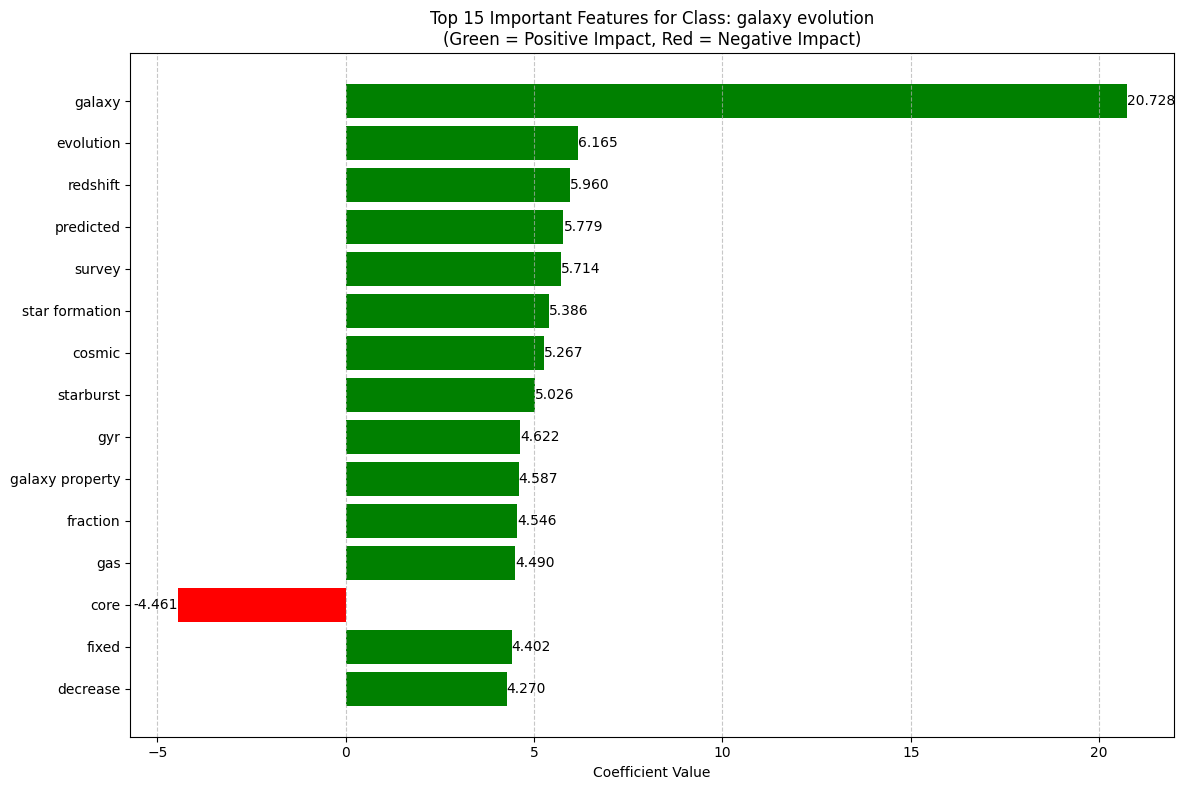


Class Statistics for 'galaxy evolution':
Total samples: 756
Percentage of dataset: 5.06%


In [7]:
# Feature importance analysis
import matplotlib.pyplot as plt

try:
    # Access model components
    tfidf = improved_model.model.named_steps['tfidf']
    clf = improved_model.model.named_steps['clf']

    # Get top class
    top_class_idx = np.argmax(np.sum(y_train, axis=0))
    top_class = mlb.classes_[top_class_idx]
    
    # Get feature importance
    coefs = clf.estimators_[top_class_idx].coef_[0]
    
    # Get top N features
    N = 15  # Increased from 10 for better analysis
    top_features = np.argsort(np.abs(coefs))[-N:]  # Using absolute values
    feature_names = np.array(tfidf.get_feature_names_out())[top_features]
    importance_scores = coefs[top_features]
    
    # Create color map based on coefficient sign
    colors = ['red' if c < 0 else 'green' for c in importance_scores]
    
    # Plot
    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(N), importance_scores, color=colors)
    
    # Add labels and formatting
    plt.yticks(range(N), feature_names)
    plt.xlabel('Coefficient Value')
    plt.title(f'Top {N} Important Features for Class: {top_class}\n(Green = Positive Impact, Red = Negative Impact)')
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2,
                f'{width:.3f}',
                ha='left' if width > 0 else 'right',
                va='center')
    
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Print additional statistics
    print(f"\nClass Statistics for '{top_class}':")
    print(f"Total samples: {np.sum(y_train[:, top_class_idx])}")
    print(f"Percentage of dataset: {100 * np.mean(y_train[:, top_class_idx]):.2f}%")
    
except AttributeError:
    print("Error: Model structure not compatible with feature importance analysis")
except IndexError:
    print("Error: No features found or empty model")
except Exception as e:
    print(f"Unexpected error during feature importance analysis: {str(e)}")

In [8]:
# Add to training script
from sklearn.model_selection import KFold
print("\n--- Running 5-Fold Cross-Validation ---")
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Use the full dataset
X_train_full = train_df['cleaned_text']
y_train_full = y 

micro_f1_scores = []

# Initialize a new model for each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_full)):
    print(f"\n--- Fold {fold + 1}/5 ---")
    X_fold_train, X_fold_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
    y_fold_train, y_fold_val = y_train_full[train_idx], y_train_full[val_idx]

    cv_model = ImprovedMultiLabelModel(config)
    cv_model.train(X_fold_train, y_fold_train)
    cv_model.optimize_thresholds(X_fold_val, y_fold_val)
    y_fold_pred = cv_model.predict(X_fold_val)

    score = f1_score(y_fold_val, y_fold_pred, average='micro')
    micro_f1_scores.append(score)
    print(f"Fold {fold+1} Micro-F1: {score:.4f}")

print("\n--- Cross-Validation Summary ---")
print(f"Average Micro-F1: {np.mean(micro_f1_scores):.4f} ± {np.std(micro_f1_scores):.4f}")


--- Running 5-Fold Cross-Validation ---

--- Fold 1/5 ---
Training base model...
Optimizing thresholds on validation set...
Threshold optimization complete.
Fold 1 Micro-F1: 0.2012

--- Fold 2/5 ---
Training base model...
Optimizing thresholds on validation set...
Threshold optimization complete.
Fold 2 Micro-F1: 0.2634

--- Fold 3/5 ---
Training base model...
Optimizing thresholds on validation set...
Threshold optimization complete.
Fold 3 Micro-F1: 0.2346

--- Fold 4/5 ---
Training base model...
Optimizing thresholds on validation set...
Threshold optimization complete.
Fold 4 Micro-F1: 0.2586

--- Fold 5/5 ---
Training base model...
Optimizing thresholds on validation set...
Threshold optimization complete.
Fold 5 Micro-F1: 0.2112

--- Cross-Validation Summary ---
Average Micro-F1: 0.2338 ± 0.0248
